In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Project

/content/drive/MyDrive/Project


In [ ]:
!ls

 convinceme_no_parse_2016_05_18.xlsx
'createdebate_released_no_parse_2016_05_18 (1).xlsx'
 createdebate_released_no_parse_2016_05_18.xlsx


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 66.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 103.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 26.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from transformers import pipeline, AutoTokenizer, AutoModel
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import torch

In [ ]:
data = pd.read_excel('convinceme_no_parse_2016_05_18.xlsx', sheet_name="text", usecols=['text_id', 'text'])

In [ ]:
data1 = pd.read_excel('convinceme_no_parse_2016_05_18.xlsx', sheet_name="discussion_stance", usecols=['discussion_stance'])

In [ ]:
data.head()

,text_id,text
0,1,"' but I have used Movie Maker', ' and I hate i..."
1,2,"' have a website', ' a blog', ' or listen to m..."
2,3,' you will use a PC because PCs are perceived ...
3,4,' why does anyone choose to waste their money ...
4,5,'Maybe you should use better software for the ...


In [ ]:
data1.head()

,discussion_stance
0,'Windows Media Maker is easier to use
1,'Mac\'s iMovie is easier to use
2,'The Beatles wrote better songs than The Rolli...
3,'The Rolling Stones wrote better songs than Th...
4,'Gay'


In [ ]:
data.text.dropna(inplace=True)
data1.discussion_stance.dropna(inplace=True)

In [ ]:
# Extract text from dataframe
text = data['text'].values.tolist()
len(text)

dis = data1['discussion_stance'].values.tolist()
len(dis)

10826

In [ ]:
text = text[:1000]


In [ ]:
dis=dis[:1000]

In [ ]:
from transformers import AutoTokenizer, AutoModel
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np

# Load data
# data = pd.read_csv("data.csv")


# Load pre-trained tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModel.from_pretrained("distilbert-base-uncased")

# Encode input text
encoded_text = []
for t in text:
    tokenized_text = tokenizer(str(t), padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        model_output = model(**tokenized_text)
    encoded_text.append(model_output.last_hidden_state.mean(dim=1).squeeze().detach().numpy())

# Convert list of arrays to a 2D numpy array
encoded_text = np.vstack(encoded_text)

# Perform K-means clustering
kmeans = KMeans(n_clusters=2, random_state=0).fit(encoded_text)

# Compute silhouette score
score = silhouette_score(encoded_text, kmeans.labels_)

# Print results
print("Silhouette score for text:", score)


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette score for text: 0.17575839


In [ ]:
from sklearn.preprocessing import StandardScaler  # to standardize the features
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

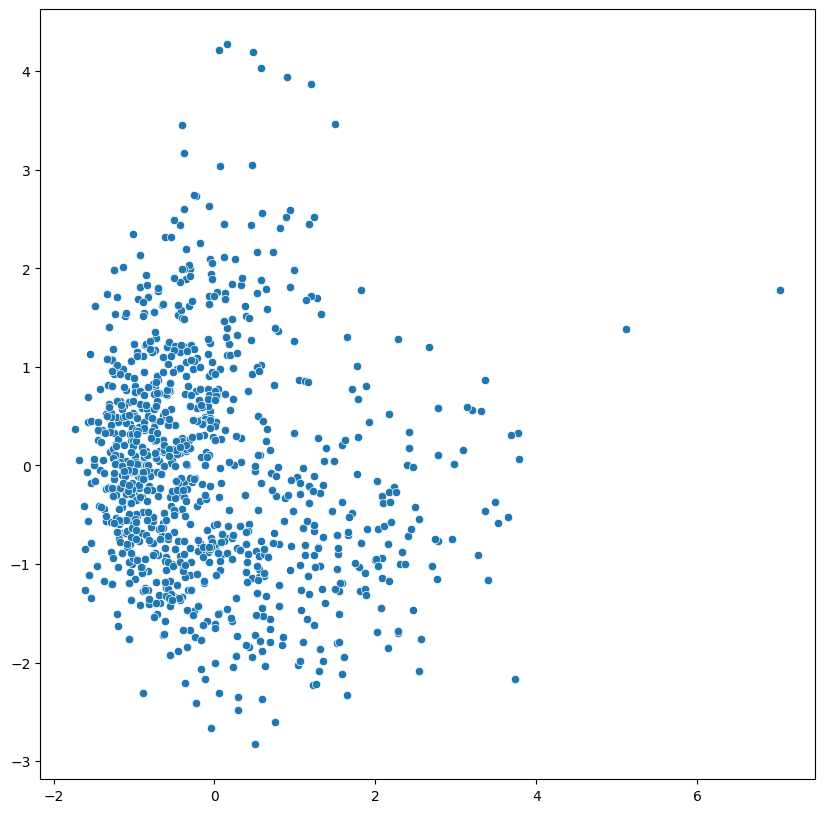

In [ ]:
pca = PCA(n_components = 2)
pca.fit(encoded_text)
data_pca = pca.transform(encoded_text)

plt.figure(figsize=(10, 10))
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1])
plt.show()

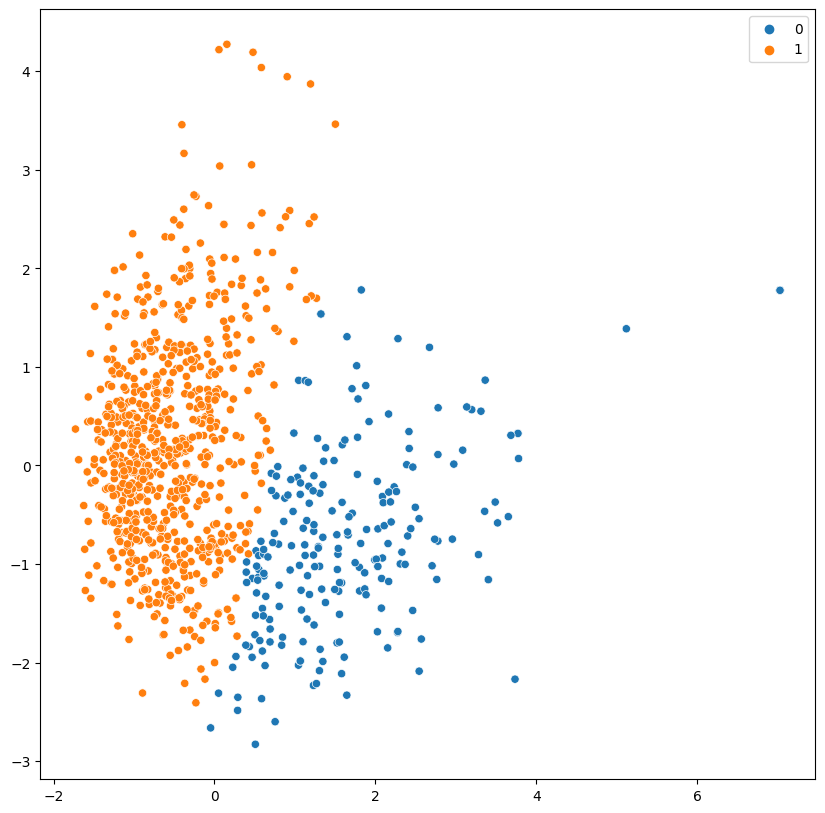

In [ ]:
# KMeans labels
y_pred = kmeans.predict(encoded_text)

plt.figure(figsize=(10, 10))
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=y_pred)
plt.show()

Silhouette score: 0.13051312


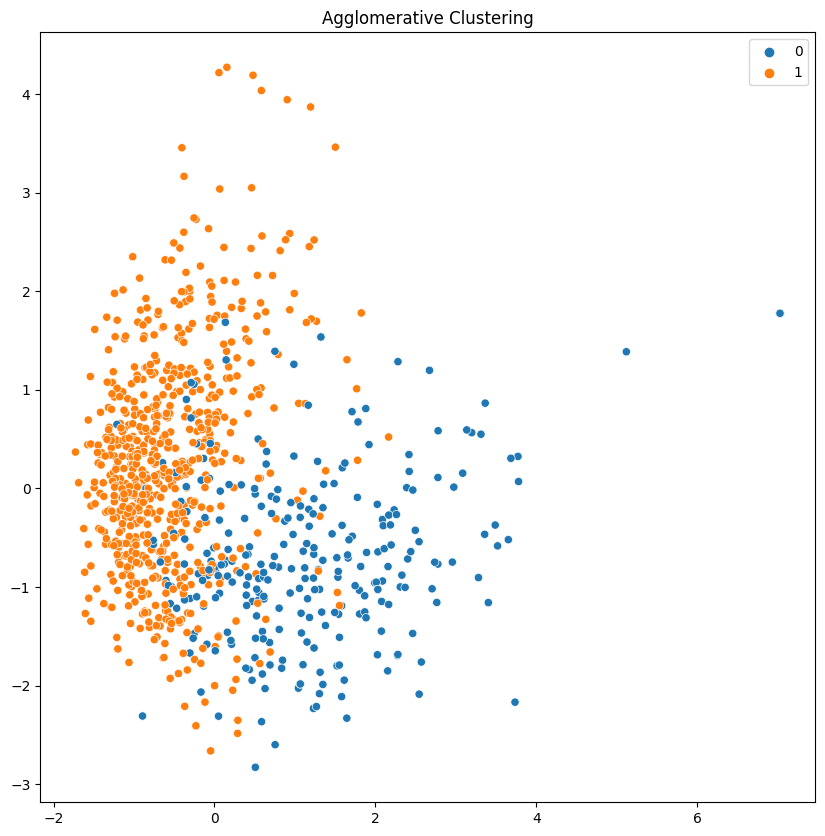

In [ ]:
from sklearn.cluster import AgglomerativeClustering

agglomerative = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='ward')
agglomerative.fit(encoded_text)
labels=agglomerative.labels_
A_score = silhouette_score(encoded_text, agglomerative.labels_)
print("Silhouette score:", A_score)

pca = PCA(n_components = 2)
pca.fit(encoded_text)
data_pca = pca.transform(encoded_text)

plt.figure(figsize=(10, 10))
plt.title("Agglomerative Clustering")
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=labels)
plt.show()

Silhouette score: 0.46


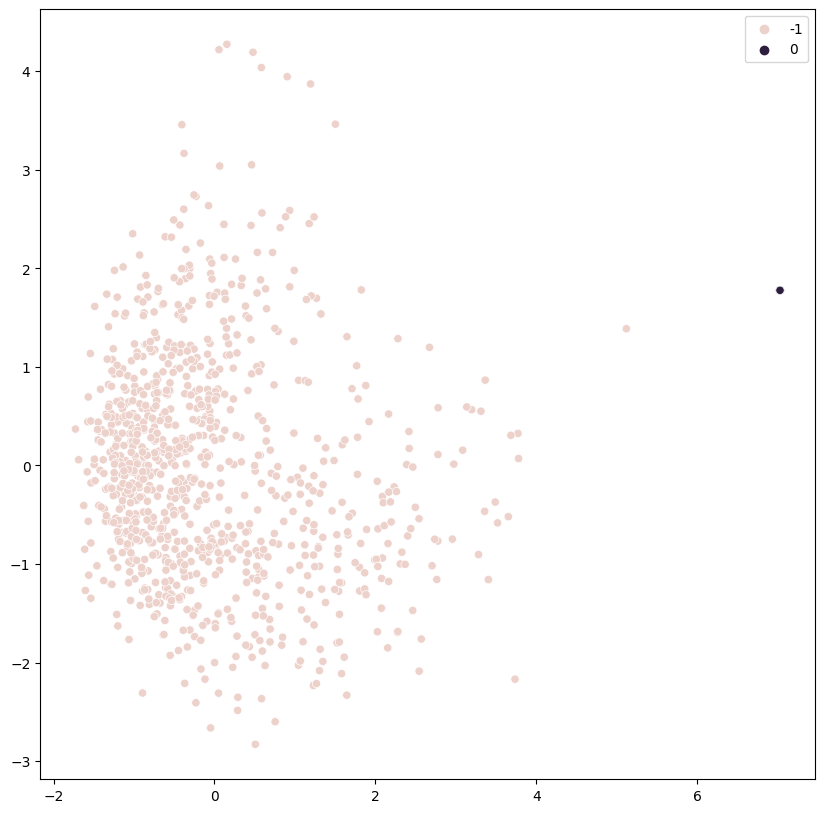

In [ ]:
#using db scan clustering

from sklearn.cluster import DBSCAN
dbscan = DBSCAN()

dbscan = DBSCAN(eps=0.4)

_ = dbscan.fit(encoded_text)


db_silhouette = silhouette_score(
    encoded_text, dbscan.labels_
).round(2)

print("Silhouette score:", db_silhouette)

db_y_pred = dbscan.labels_
# KMeans labels
plt.figure(figsize=(10, 10))
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=db_y_pred)
plt.show()

In [ ]:
from transformers import AutoTokenizer, AutoModel
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np

# Load data
# data = pd.read_csv("data.csv")


# Load pre-trained tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModel.from_pretrained("distilbert-base-uncased")

# Encode input text
encoded_text = []
for t in dis:
    tokenized_text = tokenizer(str(t), padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        model_output = model(**tokenized_text)
    encoded_text.append(model_output.last_hidden_state.mean(dim=1).squeeze().detach().numpy())

# Convert list of arrays to a 2D numpy array
encoded_text = np.vstack(encoded_text)

# Perform K-means clustering
kmeans = KMeans(n_clusters=2, random_state=0).fit(encoded_text)

# Compute silhouette score
score = silhouette_score(encoded_text, kmeans.labels_)

# Print results
print("Silhouette score for discussion stance:", score)


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette score for discussion stance: 0.13531731


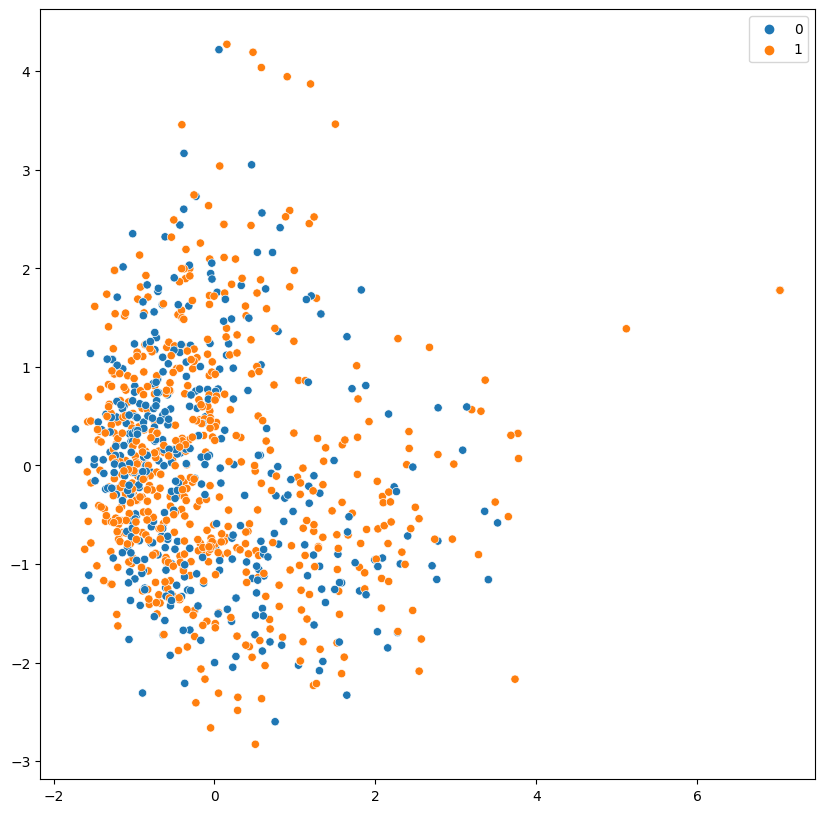

In [ ]:
# KMeans labels
y_pred = kmeans.predict(encoded_text)

plt.figure(figsize=(10, 10))
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=y_pred)
plt.show()

Silhouette score: 0.12711221


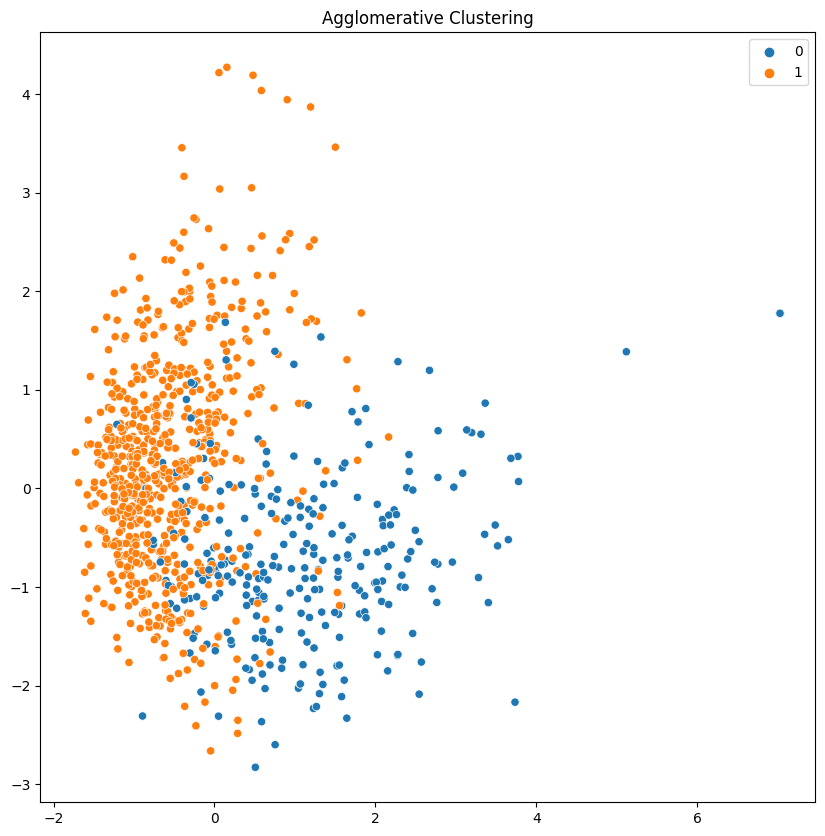

In [ ]:
#using agglomerative clustering

from sklearn.cluster import AgglomerativeClustering

agglomerative = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='ward')
agglomerative.fit(encoded_text)
A_score = silhouette_score(encoded_text, agglomerative.labels_)
print("Silhouette score:", A_score)

plt.figure(figsize=(10, 10))
plt.title("Agglomerative Clustering")
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=labels)
plt.show()


In [ ]:
from sklearn.preprocessing import StandardScaler  # to standardize the features
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt


Silhouette score: 0.06


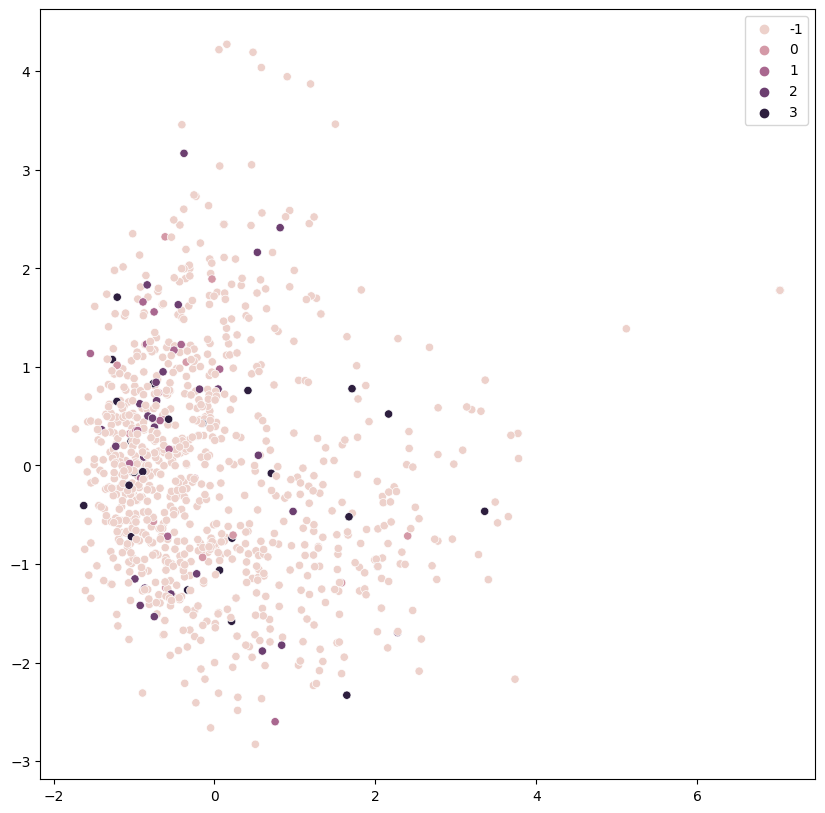

In [ ]:
#using db scan clustering

from sklearn.cluster import DBSCAN
dbscan = DBSCAN()

dbscan = DBSCAN(eps=0.4)

_ = dbscan.fit(encoded_text)


db_silhouette = silhouette_score(
    encoded_text, dbscan.labels_
).round(2)

print("Silhouette score:", db_silhouette)

db_y_pred = dbscan.labels_
# KMeans labels
plt.figure(figsize=(10, 10))
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=db_y_pred)
plt.show()